<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Task
This report will analyse the methodology used to complete assignment 2 of the course Machine Learning (COSC2673/2793). The objective of the assignment is to develop a machine-learning system that can classify traffic sign images.

The project is divided into two tasks:


*   Classify images according to the shape of the given image.
*    Classify images according to type.



## Approach
Our goal is to be able to identify the best possible machine-learning algorithm to generate a model that can reliably and consistently predict whether the type of traffic sign is based on image recognition.

# **Contact to the Drive**

In [175]:
from google.colab import drive
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder


In [176]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [177]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# **1. Data Exploration**
## **1.1 Image Visualization**

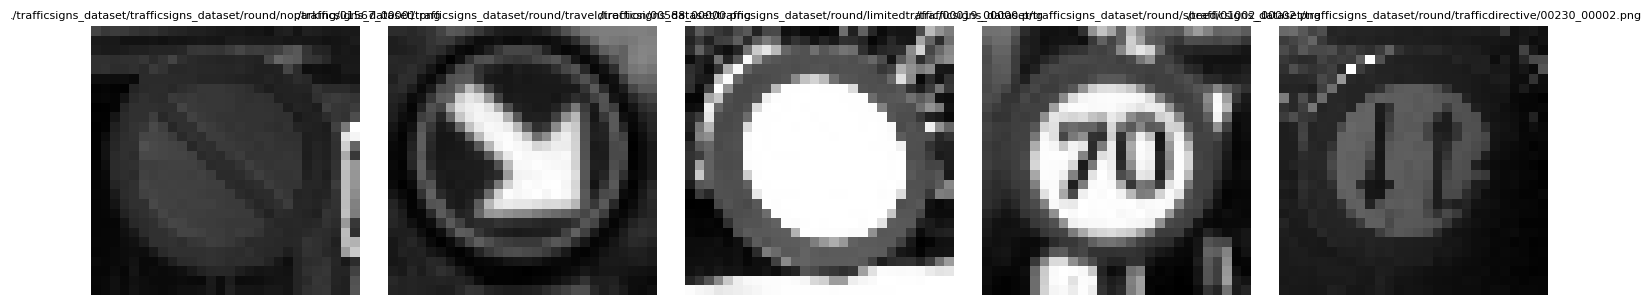

In [179]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the ZIP file and extraction directory
zip_path = '/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip'
extraction_path = './trafficsigns_dataset'

# Extracting the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Function to display images
def plot_images(images, titles, rows=1, cols=5, figsize=(15, 3)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
    for i in range(len(images)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i], fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Function to collect images from multiple directories
def collect_images(directory, extension, num_images=5, cols=5):
    images = []
    titles = []
    # Walk through each folder and subfolder
    for root, dirs, files in os.walk(directory):
        file_list = [os.path.join(root, file) for file in files if file.endswith(extension)]
        if file_list:
            selected_files = file_list[:num_images]  # Take up to num_images from each folder
            images.extend([mpimg.imread(img) for img in selected_files])
            titles.extend(selected_files)
        if len(images) >= cols:  # Limit the total number of images to display
            break
    return images, titles

# Collect and display images
image_extensions = ('.jpeg', '.jpg', '.png')
images, titles = collect_images(extraction_path, image_extensions, num_images=1, cols=5)  # Adjust num_images to pick from each folder
plot_images(images, titles)




**Observations:**
- The traffic sign images exhibit a wide variety of shapes.
- Some signs have distinctive shapes (e.g., triangles, circles, octagons), while others have more complex shapes.
- The images also vary in terms of background complexity, with some signs having simple backgrounds and others having more cluttered backgrounds.
- These observations suggest that a machine-learning algorithm will need to be able to handle a diverse range of image characteristics in order to accurately classify the traffic signs.

## **1.2 Load Data into DataFrame**

In [180]:
import os
import cv2
import pandas as pd

def load_images_into_dataframes(data_dir):
    """
    Function to load images from a directory into separate Pandas DataFrames for shape and type.

    Args:
    - data_dir (str): Path to the directory containing the data.

    Returns:
    - shape_df (DataFrame): Pandas DataFrame containing shape data with images loaded.
    - type_df (DataFrame): Pandas DataFrame containing type data with images loaded.
    """
    shape_data = []
    type_data = []

    # Iterate through shape folders
    for shape_folder in os.listdir(data_dir):
        shape_folder_path = os.path.join(data_dir, shape_folder)

        # Skip non-directory files
        if not os.path.isdir(shape_folder_path):
            continue

        # Iterate through sign type folders
        for sign_type_folder in os.listdir(shape_folder_path):
            sign_type_folder_path = os.path.join(shape_folder_path, sign_type_folder)

            # Skip non-directory files
            if not os.path.isdir(sign_type_folder_path):
                continue

            # Iterate through image files
            for image_file in os.listdir(sign_type_folder_path):
                image_path = os.path.join(sign_type_folder_path, image_file)

                # Check if the file is an image
                if not image_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    print(f"Skipping non-image file: {image_path}")
                    continue

                # Load the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Check if the image is null
                if image is None:
                    print(f"Skipping null image: {image_path}")
                    continue

                # Append image and labels to the respective data lists
                shape_data.append((image_path, image, shape_folder))
                type_data.append((image_path, image, sign_type_folder))

    # Create DataFrames from the collected data
    shape_df = pd.DataFrame(shape_data, columns=['image_path', 'image', 'shape_label'])
    type_df = pd.DataFrame(type_data, columns=['image_path', 'image', 'type_label'])

    return shape_df, type_df

# Example usage
# data_dir = "trafficsigns_dataset"
data_dir = "/content/drive/My Drive/Assignment2/trafficsigns_dataset"
shape_df, type_df = load_images_into_dataframes(data_dir)

print("Shape DataFrame:")
print(shape_df.head())

print("\nType DataFrame:")
print(type_df.head())


Skipping non-image file: /content/drive/My Drive/Assignment2/trafficsigns_dataset/triangle/warning/.DS_Store
Shape DataFrame:
                                          image_path  \
0  /content/drive/My Drive/Assignment2/trafficsig...   
1  /content/drive/My Drive/Assignment2/trafficsig...   
2  /content/drive/My Drive/Assignment2/trafficsig...   
3  /content/drive/My Drive/Assignment2/trafficsig...   
4  /content/drive/My Drive/Assignment2/trafficsig...   

                                               image shape_label  
0  [[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...      square  
1  [[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...      square  
2  [[255, 255, 255, 255, 255, 254, 254, 254, 255,...      square  
3  [[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...      square  
4  [[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...      square  

Type DataFrame:
                                          image_path  \
0  /content/drive/My Drive/Assignment2/trafficsig...   
1  /co

## **1.3 Check the Data Set**

In [181]:
# Check the size of the Shape DataFrame
print("DataFrame Size:")
print(shape_df.shape)

# Display basic information about the Shape DataFrame
print("\nDataFrame Information:")
print(shape_df.info())

# Display descriptive statistics of the Shape DataFrame
print("\nDataFrame Descriptive Statistics:")
print(shape_df.describe())

DataFrame Size:
(3699, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   3699 non-null   object
 1   image        3699 non-null   object
 2   shape_label  3699 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path  \
count                                                3699   
unique                                               3699   
top     /content/drive/My Drive/Assignment2/trafficsig...   
freq                                                    1   

                                                    image shape_label  
count                                                3699        3699  
unique                                               3699           5  
top     [[60, 64, 47, 39, 46, 33, 30

In [182]:
# Check the size of the Type DataFrame
print("DataFrame Size:")
print(type_df.shape)

# Display basic information about the Type DataFrame
print("\nDataFrame Information:")
print(type_df.info())

# Display descriptive statistics of the Type DataFrame
print("\nDataFrame Descriptive Statistics:")
print(type_df.describe())

DataFrame Size:
(3699, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3699 non-null   object
 1   image       3699 non-null   object
 2   type_label  3699 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path  \
count                                                3699   
unique                                               3699   
top     /content/drive/My Drive/Assignment2/trafficsig...   
freq                                                    1   

                                                    image type_label  
count                                                3699       3699  
unique                                               3699         16  
top     [[60, 64, 47, 39, 46, 33, 30, 33, 19

In [183]:
# Number of data points
num_data_points_1 = len(type_df)
print("Number of Data Points:", num_data_points_1)

num_data_points_2 = len(shape_df)
print("Number of Data Points:", num_data_points_2
      )

# Count of unique shapes
num_unique_shapes = shape_df['shape_label'].nunique()
print("Number of Unique Image Shapes:", num_unique_shapes)

# Count of unique types
num_unique_types = type_df['type_label'].nunique()
print("Number of Unique Image Types:", num_unique_types)

Number of Data Points: 3699
Number of Data Points: 3699
Number of Unique Image Shapes: 5
Number of Unique Image Types: 16


In [184]:
# Number of each shape
shape_counts = shape_df['shape_label'].value_counts()
print("Number of Each Shape Type:")
print(shape_counts)

# Number of each type
type_counts = type_df['type_label'].value_counts()
print("\nNumber of Each Type:")
print(type_counts)

Number of Each Shape Type:
shape_label
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64

Number of Each Type:
type_label
warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


Samples from Shape DataFrame:


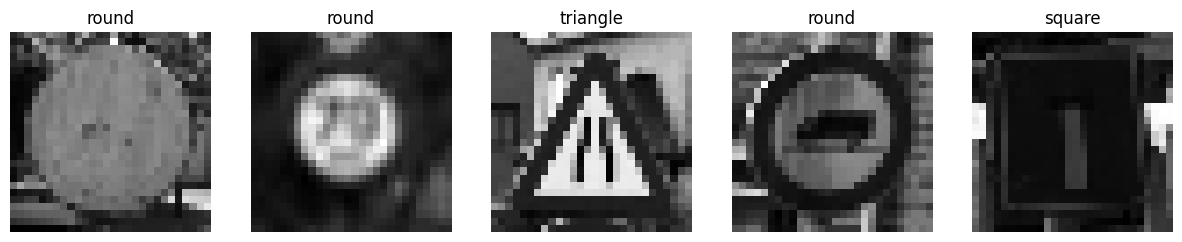

Samples from Type DataFrame:


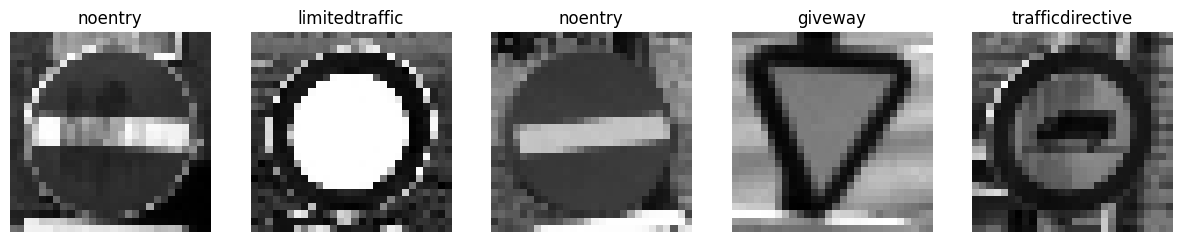

In [185]:
import matplotlib.pyplot as plt
def plot_samples(data_df, num_samples=5):
    """
    Function to plot sample images from a DataFrame along with their labels.

    Args:
    - data_df (DataFrame): DataFrame containing image data and labels.
    - num_samples (int): Number of samples to plot.

    Returns:
    - None
    """

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        sample = data_df.sample()  # Sampling from the DataFrame passed as input
        image = sample['image'].values[0]  # Assuming 'image' contains the image data
        label = sample['shape_label'].values[0] if 'shape_label' in data_df.columns else sample['type_label'].values[0]
        axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()


# Plot sample images from the shape DataFrame
print("Samples from Shape DataFrame:")
plot_samples(shape_df)

# Plot sample images from the type DataFrame
print("Samples from Type DataFrame:")
plot_samples(type_df)


In [186]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the shape labels
shape_labels_encoded = label_encoder.fit_transform(shape_df['shape_label'])

# Add the encoded labels as a new column in shape_df
shape_df['encoded_shape_label'] = shape_labels_encoded

# Display the updated shape_df
shape_df.head()

,image_path,image,shape_label,encoded_shape_label
0,/content/drive/My Drive/Assignment2/trafficsig...,"[[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...",square,3
1,/content/drive/My Drive/Assignment2/trafficsig...,"[[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...",square,3
2,/content/drive/My Drive/Assignment2/trafficsig...,"[[255, 255, 255, 255, 255, 254, 254, 254, 255,...",square,3
3,/content/drive/My Drive/Assignment2/trafficsig...,"[[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...",square,3
4,/content/drive/My Drive/Assignment2/trafficsig...,"[[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...",square,3


In [187]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the type labels
type_labels_encoded = label_encoder.fit_transform(type_df['type_label'])

# Add the encoded labels as a new column in type_df
type_df['encoded_type_label'] = type_labels_encoded

# Display the updated type_df
type_df.head()

,image_path,image,type_label,encoded_type_label
0,/content/drive/My Drive/Assignment2/trafficsig...,"[[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...",crossing,2
1,/content/drive/My Drive/Assignment2/trafficsig...,"[[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...",crossing,2
2,/content/drive/My Drive/Assignment2/trafficsig...,"[[255, 255, 255, 255, 255, 254, 254, 254, 255,...",crossing,2
3,/content/drive/My Drive/Assignment2/trafficsig...,"[[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...",crossing,2
4,/content/drive/My Drive/Assignment2/trafficsig...,"[[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...",crossing,2


In [188]:
print("Unique shapes:", shape_df['shape_label'].unique())
print("numbers of shape:", len(shape_df['shape_label'].unique()))
numbers_of_shape = len(shape_df['shape_label'].unique())

Unique shapes: ['square' 'triangle' 'hex' 'round' 'diamond']
numbers of shape: 5


In [189]:
print("Unique shapes:", type_df['type_label'].unique())
print("numbers of shape:", len(type_df['type_label'].unique()))

Unique shapes: ['crossing' 'laneend' 'parking' 'continue' 'giveway' 'warning' 'stop'
 'limitedtraffic' 'noparking' 'speed' 'noentry' 'trafficdirective'
 'roundabout' 'bicycle' 'traveldirection' 'rightofway']
numbers of shape: 16


## **1.4 Data Distribution**


### **1.4.1 Distribution of images per type class**

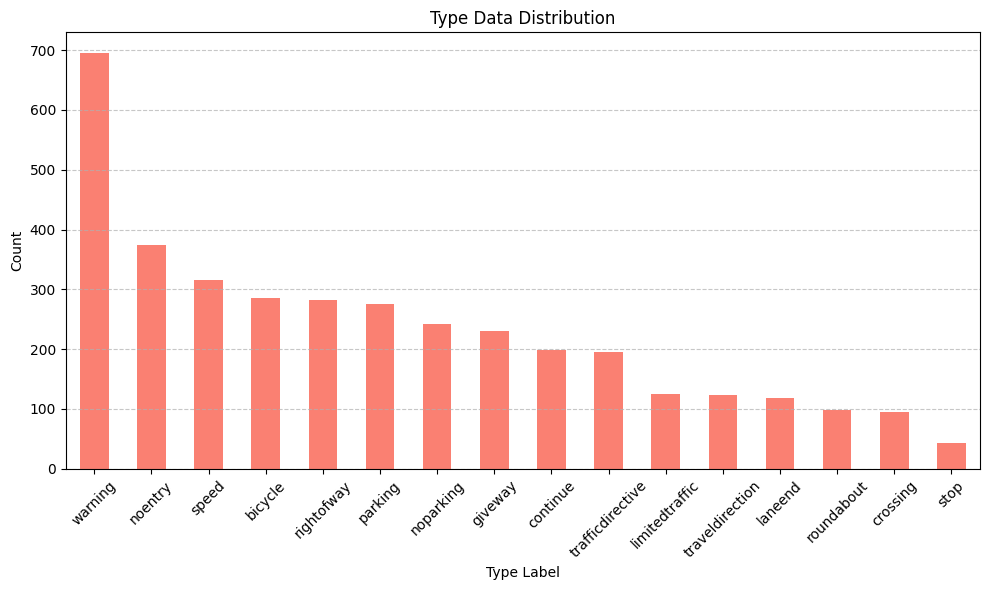

In [190]:
def visualize_data_distribution(data_df, title):
    """
    Function to visualize the distribution of data.

    Args:
    - data_df (DataFrame): Pandas DataFrame containing the data.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    data_counts = data_df['type_label'].value_counts()
    data_counts.plot(kind='bar', color='salmon')
    plt.title(title)
    plt.xlabel('Type Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize data distribution for type DataFrame
visualize_data_distribution(type_df, 'Type Data Distribution')


**Observations:**
- The distribution of images per class is imbalanced, but not as severe as the class distribution for type.
- This imbalance could potentially affect the performance of a machine-learning model trained on this data, but to a lesser extent than the type data.

### **1.4.2 Distribution of images per shape class**

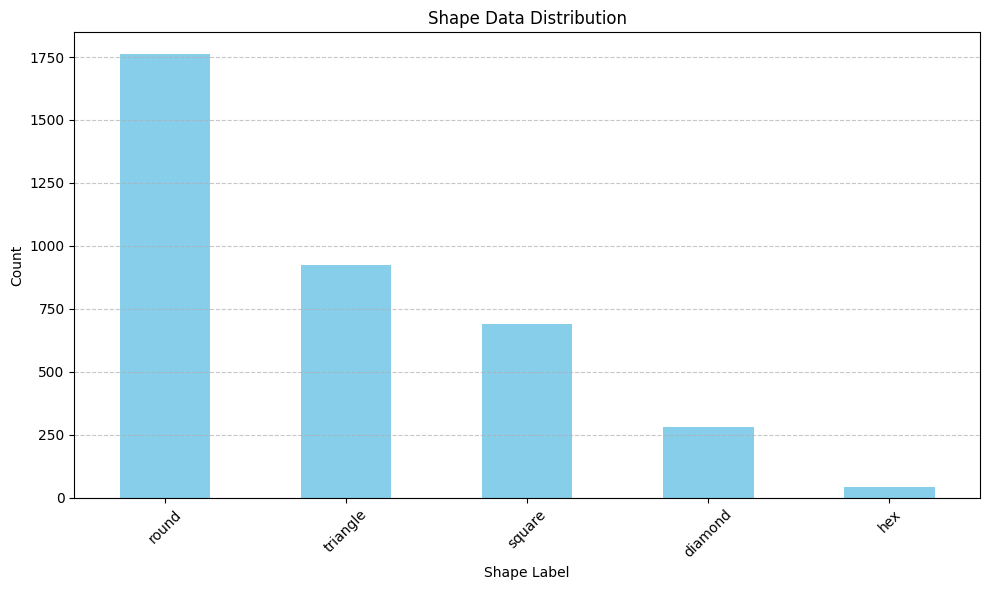

In [191]:
import matplotlib.pyplot as plt

def visualize_data_distribution(data_df, title):
    """
    Function to visualize the distribution of data.

    Args:
    - data_df (DataFrame): Pandas DataFrame containing the data.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    data_counts = data_df['shape_label'].value_counts()
    data_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Shape Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize data distribution for shape DataFrame
visualize_data_distribution(shape_df, 'Shape Data Distribution')


**Observations:**
- The distribution of images per class is highly imbalanced.
- This imbalance could potentially affect the performance of a machine-learning model trained on this data.

==========================================================================================================



# **2 Data Preparation**


## **2.1 Data spliting:  Train, Val and Test**

In [192]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling and Formatting the Images
datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Initialize lists to store training, validation, and testing data for shape and type data
X_shape_train = []
X_shape_val = []
X_shape_test = []
y_shape_train = []
y_shape_val = []
y_shape_test = []

X_type_train = []
X_type_val = []
X_type_test = []
y_type_train = []
y_type_val = []
y_type_test = []

# Split data into groups based on shape labels
shape_groups = shape_df.groupby('shape_label')

# Split data into groups based on type labels
type_groups = type_df.groupby('type_label')

# Split each shape group into training, validation, and testing sets
for label, group in shape_groups:
    print(f"\nShape group label: {label}, Shape: {group.shape[0]}")
    X_train, X_temp, y_train, y_temp = train_test_split(group['image_path'], group['encoded_shape_label'], test_size=0.2, stratify=group['shape_label'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_shape_train.extend(X_train)
    X_shape_val.extend(X_val)
    X_shape_test.extend(X_test)
    y_shape_train.extend(y_train)
    y_shape_val.extend(y_val)
    y_shape_test.extend(y_test)
    print(f"Train sample size: {len(X_train)}, Validation sample size: {len(X_val)}, Test sample size: {len(X_test)}")

# Split each type group into training, validation, and testing sets
for label, group in type_groups:
    print(f"\nType group label: {label}, Shape: {group.shape[0]}")
    X_train, X_temp, y_train, y_temp = train_test_split(group['image_path'], group['encoded_type_label'], test_size=0.2, stratify=group['type_label'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_type_train.extend(X_train)
    X_type_val.extend(X_val)
    X_type_test.extend(X_test)
    y_type_train.extend(y_train)
    y_type_val.extend(y_val)
    y_type_test.extend(y_test)
    print(f"Train sample size: {len(X_train)}, Validation sample size: {len(X_val)}, Test sample size: {len(X_test)}")

# Convert to numpy arrays for shape data
X_shape_train = np.array(X_shape_train)
X_shape_val = np.array(X_shape_val)
X_shape_test = np.array(X_shape_test)
y_shape_train = np.array(y_shape_train)
y_shape_val = np.array(y_shape_val)
y_shape_test = np.array(y_shape_test)

# Convert to numpy arrays for type data
X_type_train = np.array(X_type_train)
X_type_val = np.array(X_type_val)
X_type_test = np.array(X_type_test)
y_type_train = np.array(y_type_train)
y_type_val = np.array(y_type_val)
y_type_test = np.array(y_type_test)

# Print shapes of the data sets after splitting for shape data
print("\nShape of X_shape_train:", X_shape_train.shape)
print("Shape of X_shape_val:", X_shape_val.shape)
print("Shape of X_shape_test:", X_shape_test.shape)
print("Shape of y_shape_train:", y_shape_train.shape)
print("Shape of y_shape_val:", y_shape_val.shape)
print("Shape of y_shape_test:", y_shape_test.shape)

# Print shapes of the data sets after splitting for type data
print("\nShape of X_type_train:", X_type_train.shape)
print("Shape of X_type_val:", X_type_val.shape)
print("Shape of X_type_test:", X_type_test.shape)
print("Shape of y_type_train:", y_type_train.shape)
print("Shape of y_type_val:", y_type_val.shape)
print("Shape of y_type_test:", y_type_test.shape)



Shape group label: diamond, Shape: 282
Train sample size: 225, Validation sample size: 42, Test sample size: 15

Shape group label: hex, Shape: 43
Train sample size: 34, Validation sample size: 6, Test sample size: 3

Shape group label: round, Shape: 1760
Train sample size: 1408, Validation sample size: 264, Test sample size: 88

Shape group label: square, Shape: 688
Train sample size: 550, Validation sample size: 103, Test sample size: 35

Shape group label: triangle, Shape: 926
Train sample size: 740, Validation sample size: 139, Test sample size: 47

Type group label: bicycle, Shape: 285
Train sample size: 228, Validation sample size: 42, Test sample size: 15

Type group label: continue, Shape: 199
Train sample size: 159, Validation sample size: 30, Test sample size: 10

Type group label: crossing, Shape: 95
Train sample size: 76, Validation sample size: 14, Test sample size: 5

Type group label: giveway, Shape: 231
Train sample size: 184, Validation sample size: 35, Test sample si

## **2.2 Flatten the images**

In [193]:
import numpy as np
# from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Function to flatten images
def flatten_images(X):
    flattened_images = []
    for image_path in X:
        image = Image.open(image_path)
        image = np.array(image)
        flattened_image = image.flatten()
        flattened_images.append(flattened_image)
    return np.array(flattened_images)

# Flatten the images for shape data in training and testing sets
X_shape_train_flat = flatten_images(X_shape_train)
X_shape_test_flat = flatten_images(X_shape_test)
X_shape_val_flat = flatten_images(X_shape_val)

# Flatten the images for type data in training and testing sets
X_type_train_flat = flatten_images(X_type_train)
X_type_val_flat = flatten_images(X_type_val)
X_type_test_flat = flatten_images(X_type_test)

# Print shapes of the flattened data sets
print("\nShape of X_shape_train_flat:", X_shape_train_flat.shape)
print("Shape of X_shape_val_flat:", X_shape_val_flat.shape)
print("Shape of X_shape_test_flat:", X_shape_test_flat.shape)


print("\nShape of X_type_train_flat:", X_type_train_flat.shape)
print("Shape of X_type_val_flat:", X_type_val_flat.shape)
print("Shape of X_type_test_flat:", X_type_test_flat.shape)


Shape of X_shape_train_flat: (2957, 784)
Shape of X_shape_val_flat: (554, 784)
Shape of X_shape_test_flat: (188, 784)

Shape of X_type_train_flat: (2954, 784)
Shape of X_type_val_flat: (553, 784)
Shape of X_type_test_flat: (192, 784)


=================================================================================================

# **3. Models development**

## **3.1 Baseline Model**

In [194]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### **3.1.1Shape prediction**

In [195]:
import tensorflow as tf

INPUT_DIM = (28, 28, 1)

HIDDEN_LAYER_DIM = 256

OUTPUT_CLASSES = 5

In [196]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])


In [197]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [198]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               200960    
                                                                 
 dense_18 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


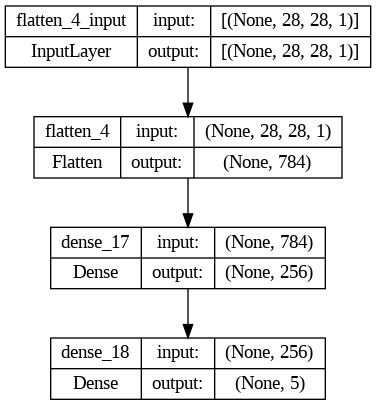

In [199]:
tf.keras.utils.plot_model(model, show_shapes=True)

### **Image generator**

In [200]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


df_X_shape_train = pd.DataFrame({
    'image_path': X_shape_train,
    'encoded_shape_label': y_shape_train
})
df_X_shape_val = pd.DataFrame({
    'image_path': X_shape_val,
    'encoded_shape_label': y_shape_val
})

df_X_shape_train['encoded_shape_label'] = df_X_shape_train['encoded_shape_label'].astype(str)
df_X_shape_val['encoded_shape_label'] = df_X_shape_val['encoded_shape_label'].astype(str)

# Defining image data generators
datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Create training data generator
train_generator = datagen_shape.flow_from_dataframe(
    dataframe=df_X_shape_train,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')



# Create validation data generator
validation_generator = datagen_shape.flow_from_dataframe(
    dataframe=df_X_shape_val,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')


Found 2957 validated image filenames belonging to 5 classes.
Found 554 validated image filenames belonging to 5 classes.


In [201]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=0)


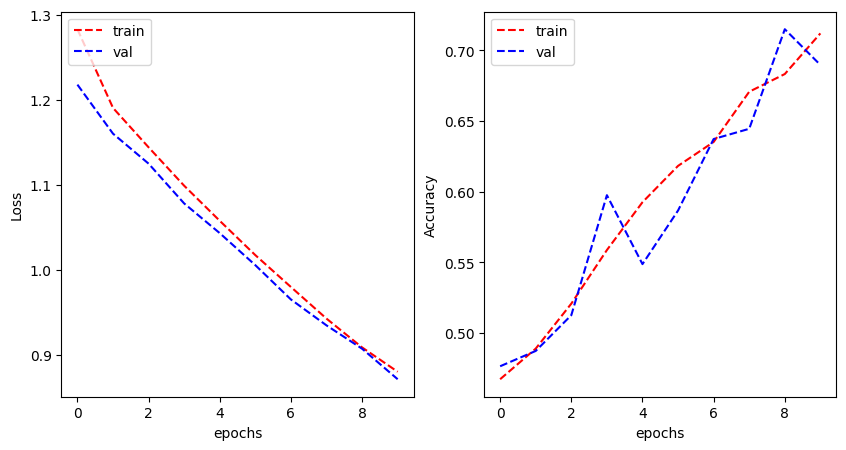

In [202]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [203]:


df_X_shape_test = pd.DataFrame({
    'image_path': X_shape_test,
    'encoded_shape_label': y_shape_test
})

df_X_shape_test['encoded_shape_label'] = df_X_shape_test['encoded_shape_label'].astype(str)



test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_X_shape_test,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')



Found 188 validated image filenames belonging to 5 classes.


In [204]:
model.evaluate(test_generator)

6/6 [==============================] - 1s 128ms/step - loss: 0.9112 - categorical_accuracy: 0.6596


[0.9112338423728943, 0.6595744490623474]

==================Afrah


### **3.1.2 Type prediction**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping  # Import EarlyStopping


# Define the MLP model
def type_mlp(input_type, num_classes):
    model_2 = Sequential([
        Dense(128, activation='sigmoid', input_dim=input_type),  # Changed 'input_type' to 'input_dim'
        Dense(64, activation='sigmoid'),
        Dense(num_classes, activation='softmax')
    ])
    return model_2

# Set input shape
input_type = X_type_train_flat.shape[1]

# Number of classes
num_classes = len(np.unique(y_type_train))

# Build the MLP model
mlp_model = type_mlp(input_type, num_classes)

# Compile the model
mlp_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='SGD',
                   metrics=['accuracy'])

# Print model summary
mlp_model.summary()

# Train the model with validation data
history = mlp_model.fit(X_type_train_flat, y_type_train, epochs=10, batch_size=32, validation_data=(X_type_val_flat, y_type_val), callbacks=[early_stopping])

# Evaluate the model on the train data
train_loss_type, train_accuracy_type = mlp_model.evaluate(X_type_train_flat, y_type_train)
print("Train Loss for Type:", train_loss_type)
print("Train Accuracy for Type:", train_accuracy_type)

# Evaluate the model on the validation data
val_loss_type, val_accuracy_type = mlp_model.evaluate(X_type_val_flat, y_type_val)
print("Validation Loss for Type:", val_loss_type)
print("Validation Accuracy for Type:", val_accuracy_type)


In [ ]:
import numpy as np

from sklearn.metrics import classification_report

# Predict classes for test data
y_pred = np.argmax(mlp_model.predict(X_type_test_flat), axis=1)

# Generate classification report
report = classification_report(y_type_test, y_pred)

# Print the classification report
print("Classification Report:\n", report)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities for the test data
y_pred_probs = mlp_model.predict(X_type_test_flat)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix for test data
conf_mat_test = confusion_matrix(y_type_test, y_pred)

# Plot confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['accuracy'], history.history['val_accuracy'],
                    metric_name='Accuracy')


**Observations:**

- The baseline MLP model achieved a test accuracy of approximately 30% for both shape and type classification.
- The confusion matrices for both shape and type classification show that the model struggles to distinguish between certain classes.
- The learning curves indicate that the model may be underfitting the data, as the training and validation loss curves do not converge.

**Possible Improvements:**

- Experiment with different network architectures (e.g., number of layers, activation functions).
- Hyperparameter tuning (e.g., learning rate, optimizer, batch size).
- Data augmentation to increase the size and diversity of the training data.
- Exploring other machine learning algorithms such as convolutional neural networks (CNNs) which are specifically designed for image classification tasks.



=====================================================================================================

# **3.2 Building baseline model using  Visual Geometry Group (VGG)**

In [ ]:
# install tensorflow library
import tensorflow as tf

# optimise data pipeline performance automatically
AUTOTUNE = tf.data.experimental.AUTOTUNE

# print the version of TensorFlow
tf.__version__

In [ ]:
def create_VGG_Model(num_classes):
    input_dimension = (28, 28, 1)
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=input_dimension),
        tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_VGG_Model(10)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf

# Reshape the data using TensorFlow
X_shape_train_vgg = tf.reshape(X_shape_train_flat, (-1, 28, 28, 1))
X_shape_val_vgg = tf.reshape(X_shape_val_flat, (-1, 28, 28, 1))
X_shape_test_vgg = tf.reshape(X_shape_test_flat, (-1, 28, 28, 1))

In [ ]:
# Assuming num_classes is defined (e.g., 10 for MNIST digits)
num_classes = 5  # Update this based on your actual number of classes
VGG_model_shape = create_VGG_Model(num_classes)

# Compile the model
VGG_model_shape.compile(
    optimizer='SGD',  # Using SGD optimizer
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
# Train the model using the reshaped data
history_vgg1 = VGG_model_shape.fit(
    X_shape_train_vgg,  # Reshaped training data
    y_shape_train,  # Training labels
    validation_data=(X_shape_val_vgg, y_shape_val),  # Reshaped validation data and labels
    epochs=10,
    verbose=1,
    callbacks=[early_stopping])

In [ ]:
# Evaluate the model on the training data
train_loss_shape_vgg, train_accuracy_shape_vgg = VGG_model_shape.evaluate(X_shape_train_vgg, y_shape_train)
print("Training Loss for Shape VGG Model:", train_loss_shape_vgg)
print("Training Accuracy Shape VGG Model:", train_accuracy_shape_vgg)

# Evaluate the model on the validation data
val_loss_shape_vgg, val_accuracy_shape_vgg = VGG_model_shape.evaluate(X_shape_val_vgg, y_shape_val)
print("Validation Loss:", val_loss_shape_vgg)
print("Validation Accuracy:", val_accuracy_shape_vgg)


In [ ]:
import numpy as np

from sklearn.metrics import classification_report

# Predict classes for test data
y_pred = np.argmax(VGG_model_shape.predict(X_shape_test_vgg), axis=1)

# Generate classification report
report = classification_report(y_shape_test, y_pred)

# Print the classification report
print("Classification Report:\n", report)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities for the test data
y_pred_probs = VGG_model_shape.predict(X_shape_test_vgg)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix for test data
conf_mat_test = confusion_matrix(y_shape_test, y_pred)

# Plot confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
plot_learning_curve(history_vgg1.history['loss'], history_vgg1.history['val_loss'],
                    history_vgg1.history['accuracy'], history_vgg1.history['val_accuracy'],
                    metric_name='Accuracy')

The plot shows the learning curves for the VGG model trained on the shape data. The learning curves depict the model's performance on both training and validation datasets across epochs.

- **Training Loss and Validation Loss:**
  - The training loss curve shows a decreasing trend, indicating the model is learning from the data.
  - The validation loss curve initially decreases but then starts to increase, suggesting potential overfitting.

- **Training Accuracy and Validation Accuracy:**
  - The training accuracy curve shows an increasing trend, reaching a high value.
  - The validation accuracy curve also increases but reaches a lower value compared to the training accuracy, indicating some overfitting.

- **Observations:**
  - The model achieves a high training accuracy but a lower validation accuracy, suggesting a gap between its performance on the training and validation data.
  - The increasing validation loss indicates the model may be memorizing the training data rather than generalizing well to unseen data.

- **Possible Improvements:**
  - Regularization techniques like dropout or data augmentation could be applied to reduce overfitting.
  - Hyperparameter tuning of the learning rate, optimizer, and other parameters might be necessary to achieve better generalization.
  - Exploring other network architectures or data preprocessing techniques could potentially enhance the model's performance.

Overall, the plot suggests the VGG model requires further optimization to improve its generalization capabilities and reduce overfitting.


# **Data Augmentation**

**Recognizing the imbalance in our data, we plan to explore whether supplementing the smaller classes with augmented data can enhance the accuracy of our model. In this section, we will establish new folders to house the augmented datasets derived from the original training data.**

In [ ]:
# Determine the maximum count in any single category
max_count = max([len(group) for label, group in shape_groups])

# Calculate augmentation needs for each category
augment_needs = {}
for label, group in shape_groups:
    current_count = len(group)
    augment_needs[label] = max(0, max_count - current_count)  # Only augment if needed


In [ ]:
max_count

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np

# Initialize the ImageDataGenerator with transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Augment the images based on their needs
augmented_images = []
for label, group in shape_groups:
    images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in group['image_path']]
    num_to_augment = augment_needs[label]
    augmented_count = 0

    for img in images:
        if augmented_count >= num_to_augment:
            break
        img = cv2.resize(img, (28, 28))
        img = img.reshape(1, 28, 28, 1)  # Reshape to fit the ImageDataGenerator requirements
        aug_iter = datagen.flow(img, batch_size=1)

        for _ in range(5):  # Generate multiple augmented images from each original image
            aug_img = next(aug_iter)[0]
            augmented_images.append(aug_img)
            augmented_count += 1
            if augmented_count >= num_to_augment:
                break


In [ ]:
# Initialize shape_counts for both 'original' and 'augmented'
shape_counts = {label: {'original': 0, 'augmented': 0} for label in shape_groups.groups.keys()}
# Split each shape group into training and testing sets and update counts
for label, group in shape_groups:
    X_train, X_test, y_train, y_test = train_test_split(
        group['image_path'], group['encoded_shape_label'], test_size=0.2, stratify=group['shape_label'])
    shape_counts[label]['original'] += len(X_train)  # Update original count with the number of training images
    print(f"Shape group label: {label}, Train: {len(X_train)}, Test: {len(X_test)}")
# Assuming you track augmented images correctly
for label, group in shape_groups:
    # Simulate augmenting images
    num_augments = 5 * len(X_train)  # Assuming you augment each image 5 times
    shape_counts[label]['augmented'] += num_augments  # Update augmented count
# Plotting the distribution of images for shapes
labels, original_counts, augmented_counts = zip(*[
    (label, counts['original'], counts['augmented']) for label, counts in shape_counts.items()
])

indexes = np.arange(len(labels))
width = 0.35

plt.bar(indexes, original_counts, width, label='Original')
plt.bar(indexes + width, augmented_counts, width, label='Augmented', color='red')

plt.ylabel('Number of Images')
plt.title('Number of Images by Shape Before and After Augmentation')
plt.xticks(indexes + width / 2, labels, rotation='vertical')
plt.legend()
plt.show()


**Observations:**

- After applying augmentation, the number of images in each shape category is now balanced.
- This augmentation approach can potentially improve the performance of a machine-learning model trained on this data by providing more representative data for each shape class.

In [ ]:
# Initialize type_counts for both 'original' and 'augmented'
type_counts = {label: {'original': 0, 'augmented': 0} for label in type_groups.groups.keys()}
# Split each type group into training and testing sets and update counts
for label, group in type_groups:
    X_train, X_test, y_train, y_test = train_test_split(
        group['image_path'], group['encoded_type_label'], test_size=0.2, stratify=group['type_label'])
    type_counts[label]['original'] += len(X_train)  # Update original count with the number of training images
    print(f"type group label: {label}, Train: {len(X_train)}, Test: {len(X_test)}")
# Assuming you track augmented images correctly
for label, group in type_groups:
    # Simulate augmenting images
    num_augments = 5 * len(X_train)  # Assuming you augment each image 5 times
    type_counts[label]['augmented'] += num_augments  # Update augmented count
# Plotting the distribution of images for shapes
labels, original_counts, augmented_counts = zip(*[
    (label, counts['original'], counts['augmented']) for label, counts in type_counts.items()
])

indexes = np.arange(len(labels))
width = 0.35

plt.bar(indexes, original_counts, width, label='Original')
plt.bar(indexes + width, augmented_counts, width, label='Augmented', color='red')

plt.ylabel('Number of Images')
plt.title('Number of Images by Type Before and After Augmentation')
plt.xticks(indexes + width / 2, labels, rotation='vertical')
plt.legend()
plt.show()

**Observations:**

- After applying augmentation, the number of images in each type category is now more balanced.
- This augmentation approach can potentially improve the performance of a
machine-learning model trained on this data by providing more representative data for each type class.


Regularization

Drop out

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1]
}

# Create the model
model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
